In [1]:
# === DataFrame libraies ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ===== Pipeline libraries ====
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
# ===== Models libraries ====
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
# ===== Evaluation metrics ====
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [209]:
# Model performance functions

def model_statistics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}")

def plot_model_performance(y_test, y_pred):
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    
    # Plot the ideal diagonal line (y = x)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    
    plt.tight_layout()
    plt.show()

def collect_all_model_statistics(y_test_no, y_test_base, predictions_dict):
    stats = []
    for name, y_pred in predictions_dict.items():

        if name == "Baseline":
            y_test = y_test_base
        else:
            y_test = y_test_no
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        stats.append({
            'Model': name,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'RMSE': round(rmse, 2),
            'R²': round(r2, 4)
        })
    
    return pd.DataFrame(stats)

# DATASET ANALYSIS

In [130]:
df = pd.read_csv('product_forecast.csv')

In [4]:
df.head(3)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [48]:
df[df.isnull().any(axis=1)]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,193915,23/04/13,9436,245338,NaN,469.5375,0,0,1


array([[<Axes: title={'center': 'record_ID'}>,
        <Axes: title={'center': 'store_id'}>,
        <Axes: title={'center': 'sku_id'}>],
       [<Axes: title={'center': 'total_price'}>,
        <Axes: title={'center': 'base_price'}>,
        <Axes: title={'center': 'is_featured_sku'}>],
       [<Axes: title={'center': 'is_display_sku'}>,
        <Axes: title={'center': 'units_sold'}>, <Axes: >]], dtype=object)

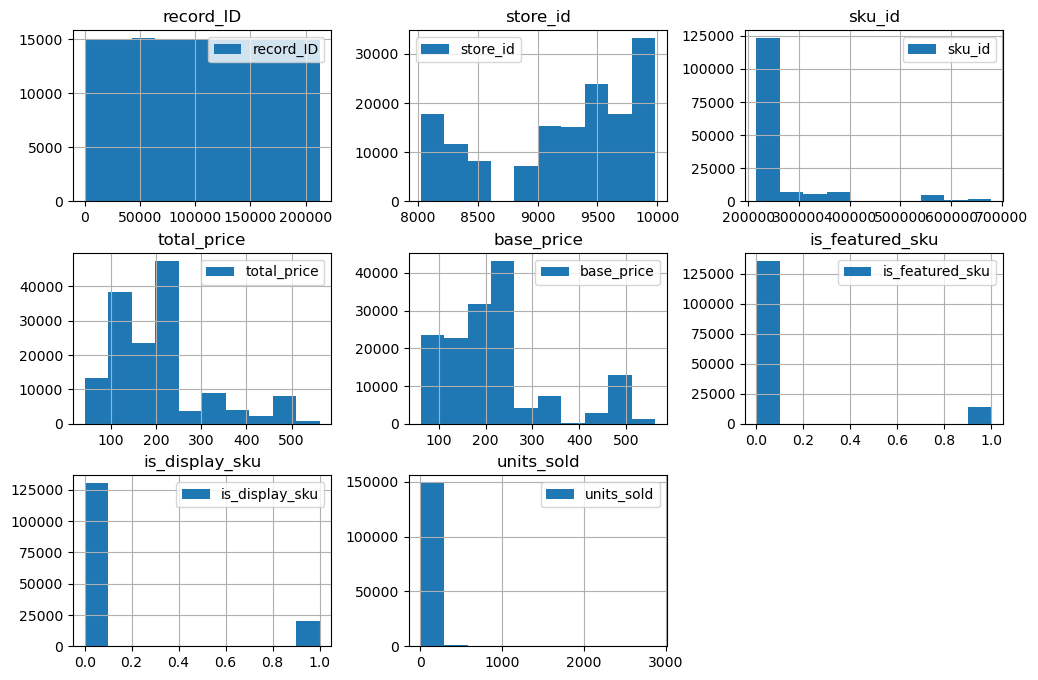

In [49]:
df.hist(legend = True, figsize = (12,8))

## 🔍 Initial Data Analysis & Observations
Before building a predictive model, it is essential to understand the structure and quality of the dataset.
## Preliminary analysis:
### 1. Missing Values
- The dataset contains a **very limited number of null values**, affecting only a single row.
- Given this minimal presence and to maintain data balance, the row with null values can be **dropped** without any need for imputation.
### 2. `record_id`
- This column serves as a unique identifier for each record.
- Since all values are distinct and do not contribute to the prediction task, this column can be safely **removed** from the dataset.
### 3. `store_id` and `sku_id`
- These categorical identifiers represent store locations and product SKUs.
- Initial distribution analysis suggests an **imbalance**, which may affect the model's performance.
### 4. `week`
- This column is currently stored in an **object (string)** format.
- To make it usable for modeling, the column will be **transformed** by splitting it into **individual numerical components** to reflect time progression effectively.
### 5. Outliers in `units_sold`
- Preliminary analysis suggests the presence of **outliers** in the `units_sold` column.

In [50]:
df.units_sold.describe()

count    150150.000000
mean         51.674206
std          60.207904
min           1.000000
25%          20.000000
50%          35.000000
75%          62.000000
max        2876.000000
Name: units_sold, dtype: float64

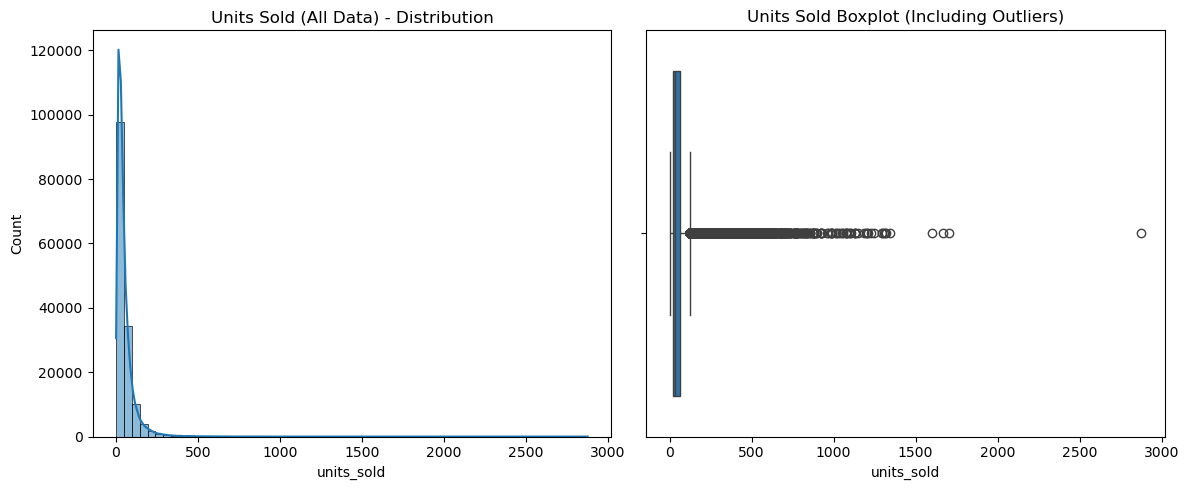

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df.units_sold, kde=True, bins=60, ax=ax1)
ax1.set_title("Units Sold (All Data) - Distribution")

sns.boxplot(x=df.units_sold, ax=ax2)
ax2.set_title("Units Sold Boxplot (Including Outliers)")

plt.tight_layout()
plt.show()

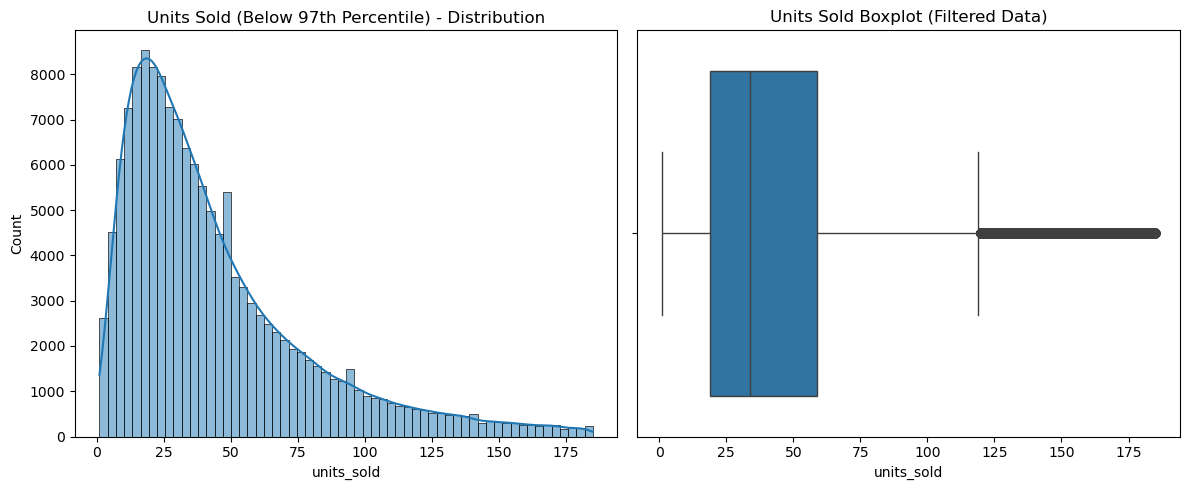

In [52]:
df_analysis = df.copy()
df_analysis = df_analysis[df_analysis.units_sold < df_analysis.units_sold.quantile(0.97)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_analysis.units_sold, kde=True, bins=60, ax=ax1)
ax1.set_title("Units Sold (Below 97th Percentile) - Distribution")

sns.boxplot(x=df_analysis.units_sold, ax=ax2)
ax2.set_title("Units Sold Boxplot (Filtered Data)")

plt.tight_layout()
plt.show()

In [53]:
print(f"Total Number of Unique Store IDs: {df.store_id.nunique()}")
print(f"Total Number of Unique SKU IDs: {df.sku_id.nunique()}")

Total Number of Unique Store IDs: 76
Total Number of Unique SKU IDs: 28


## 🏪 `store_id`, `sku_id`, and `units_sold` Analysis
### 1. `units_sold` Distribution:
- From the previous histogram and boxplot visualizations, we observed that the `units_sold` feature contained outliers, especially in the top 3% of values.
- By filtering the data up to the **97th percentile**, the distribution becomes more **normalized** and **less skewed**.
- This filtering improves the dataset quality and is likely to enhance model performance by reducing noise and the impact of extreme values during training.
### 2. `store_id` and `sku_id` Cardinality:
- The dataset contains **76 unique store IDs** and **28 unique SKU IDs**, resulting in **over 100 categorical values** in total.
- Applying **One-Hot Encoding** to these high-cardinality features would create more than 100 additional columns, leading to:
  - **Increased memory usage**
  - **Sparsity in the dataset**
  - **Longer training time**, especially for models sensitive to dimensionality like linear regression.
### Encoding Strategy:
- Instead of one-hot encoding, we choose **Label Encoding**, which assigns each unique ID a numeric label.
- This method is **computationally efficient**, reduces dimensionality, and helps maintain a well-structured dataset.
- While Label Encoding may introduce an **ordinal relationship** (which doesn't naturally exist), many models like **tree-based algorithms** can still handle this effectively without performance degradation.

# 📉 Baseline Model

We now establish a baseline by fitting the raw numerical features into a **Random Forest Regressor**. This initial model helps us evaluate future improvements by providing a reference point for performance.

In [154]:
# Preprocessing data for base line
df_base_line = df.copy().dropna()
df_base_line[['day', 'month', 'year']] = df_base_line['week'].str.split('/', expand = True)
df_base_line = df_base_line.drop('week', axis = 1)
# Train and Data sets for base line
X_base = df_base_line.drop('units_sold', axis = 1)
y_base = df_base_line.units_sold
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base,y_base, test_size=0.2)

In [155]:
base_model = RandomForestRegressor()
base_model.fit(X_train_base, y_train_base)
y_pred_base = base_model.predict(X_test_base)

In [156]:
model_statistics(y_test_base, y_pred_base)

MAE:  13.99
MSE:  890.33
RMSE: 29.84
R²:   0.7581


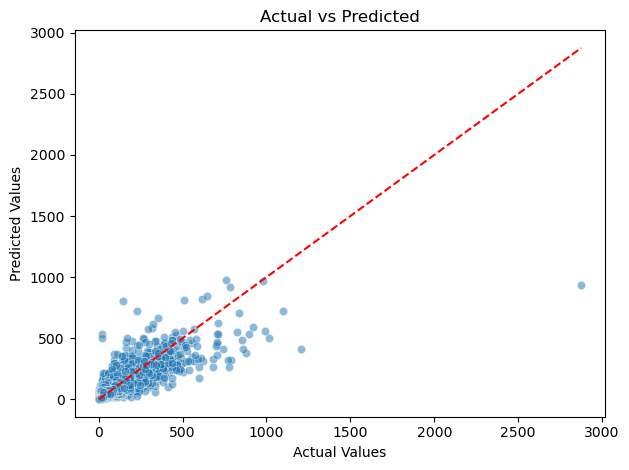

In [157]:
plot_model_performance(y_test_base, y_pred_base)

# 🧪 Modeling Pipelines


In this section, we implement two complete modeling pipelines, each designed to improve prediction performance by including preprocessing, hyperparameter optimization, and target normalizatio.

### 🔧 Pipeline 1: Random Forest Regre Improvementssor
- Data preprocessing  
- Hyperparameter tuning to optimize the `RandomForestRegressor`  
- Target normalization for `unit_old`

### 🚀 Pipeline 2: CatBoost Regressor
- Data preprocessing  
- Hyperparameter tuning for the `CatBoostRegressor` (a gradient boosting algorithm)  
- Target normalization for `units_sold`

In [9]:
class DataPreprocessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y= None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Drop store_id
        X = X.drop('record_ID', axis = 1)

        # Preprocess Date
        X[['day', 'month', 'year']] = X['week'].str.split('/', expand = True).astype(int)
        X = X.drop('week', axis = 1)

        # Store, SKU ID Label Encoding
        le_store = LabelEncoder()
        le_sku = LabelEncoder()
        X['store_id_le'] = le_store.fit_transform(X['store_id'])
        X['sku_id_le'] = le_sku.fit_transform(X['sku_id'])
        X = X.drop(['store_id', 'sku_id'], axis = 1)

        return X

In [87]:
# Pipelines architecture
pipe_1 = Pipeline([
    ('preprocessing', DataPreprocessing()),
     ('regressor', RandomForestRegressor(n_jobs=-1))
])

pipe_2 = Pipeline([
    ('preprocessing', DataPreprocessing()),
    ('regressor', CatBoostRegressor())
])

In [11]:
# Target normalization
rfr_model = TransformedTargetRegressor(
    regressor=pipe_1,
    func=np.log1p,
    inverse_func=np.expm1 
)

cbr_model = TransformedTargetRegressor(
    regressor=pipe_2,
    func=np.log1p,
    inverse_func=np.expm1 
)

In [86]:
# Hyperparameter tuning
rfr_param_grid = {
    'regressor__regressor__n_estimators':[100, 200, 300]
}

rfr_grid_search = GridSearchCV(rfr_model, rfr_param_grid, cv=5, scoring='r2', return_train_score=True)

cbr_param_grid = {
    'regressor__regressor__iterations': [500, 1000],
    'regressor__regressor__depth': [12]
}

cbr_grid_search = GridSearchCV(cbr_model, cbr_param_grid, cv=5, scoring='r2', return_train_score=True)

In [181]:
# Train and test sets
df_pl = df.copy().dropna()
df_pl = df_pl[df_pl.units_sold < df_pl.units_sold.quantile(0.97)]

# Train and Data sets for base line
X = df_pl.drop('units_sold', axis = 1)
y = df_pl.units_sold
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

# 📉 Pipeline 1 Results

In [189]:
# Fit the pipeline
rfr_grid_search.fit(X_train, y_train)
# Choose model with best hiperparameters
best_rfr_model = rfr_grid_search.best_estimator_

In [190]:
# rfr model predictions
y_pred_rfr = best_rfr_model.predict(X_test)

In [191]:
model_statistics(y_test, y_pred_rfr)

MAE:  11.33
MSE:  293.00
RMSE: 17.12
R²:   0.7622


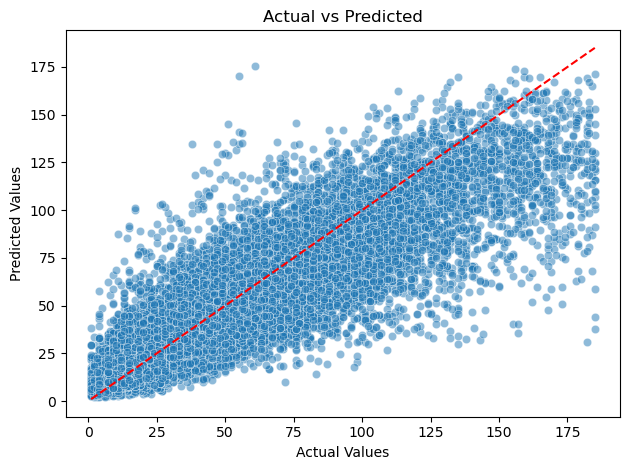

In [192]:
plot_model_performance(y_test, y_pred_rfr)

# 📉 Pipeline 2 Results

In [193]:
# Fit the pipeline
cbr_grid_search.fit(X_train, y_train)
# Choose model with best hiperparameters
best_cbr_model = cbr_grid_search.best_estimator_

Learning rate set to 0.147262
0:	learn: 0.7513186	total: 66.7ms	remaining: 33.3s
1:	learn: 0.7200542	total: 117ms	remaining: 29.1s
2:	learn: 0.6935621	total: 164ms	remaining: 27.2s
3:	learn: 0.6727212	total: 214ms	remaining: 26.5s
4:	learn: 0.6572595	total: 262ms	remaining: 25.9s
5:	learn: 0.6445346	total: 308ms	remaining: 25.4s
6:	learn: 0.6325076	total: 356ms	remaining: 25.1s
7:	learn: 0.6226892	total: 404ms	remaining: 24.9s
8:	learn: 0.6125383	total: 452ms	remaining: 24.7s
9:	learn: 0.6054189	total: 500ms	remaining: 24.5s
10:	learn: 0.5974651	total: 547ms	remaining: 24.3s
11:	learn: 0.5912802	total: 598ms	remaining: 24.3s
12:	learn: 0.5865062	total: 644ms	remaining: 24.1s
13:	learn: 0.5819528	total: 694ms	remaining: 24.1s
14:	learn: 0.5748845	total: 744ms	remaining: 24.1s
15:	learn: 0.5690432	total: 792ms	remaining: 24s
16:	learn: 0.5646898	total: 840ms	remaining: 23.9s
17:	learn: 0.5600118	total: 888ms	remaining: 23.8s
18:	learn: 0.5572295	total: 939ms	remaining: 23.8s
19:	learn: 0

In [194]:
# rfr model predictions
y_pred_cbr = best_cbr_model.predict(X_test)

In [195]:
model_statistics(y_test, y_pred_cbr)

MAE:  9.70
MSE:  200.45
RMSE: 14.16
R²:   0.8373


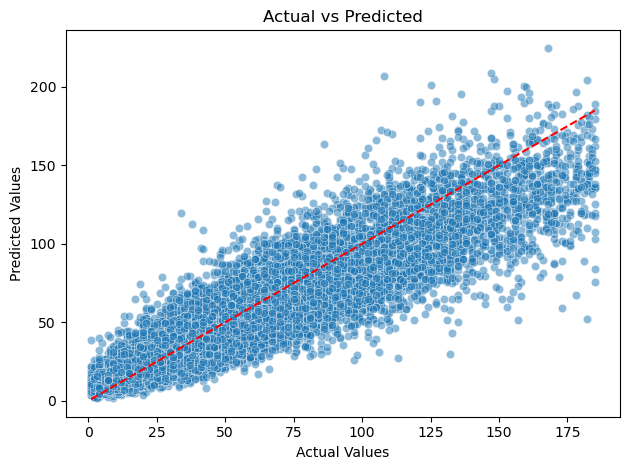

In [196]:
plot_model_performance(y_test, y_pred_cbr)

# 📉 Models Analysis and Conclusions

In [198]:
predictions = {
    "Random Forest": y_pred_rfr,
    "CatBoost": y_pred_cbr,
    "Baseline": y_pred_base
}

In [210]:
metrics_df = collect_all_model_statistics(y_test, y_test_base, predictions)
metrics_df

,Model,MAE,MSE,RMSE,R²
0,Random Forest,11.33,293.00,17.12,0.7622
1,CatBoost,9.70,200.45,14.16,0.8373
2,Baseline,13.99,890.33,29.84,0.7581


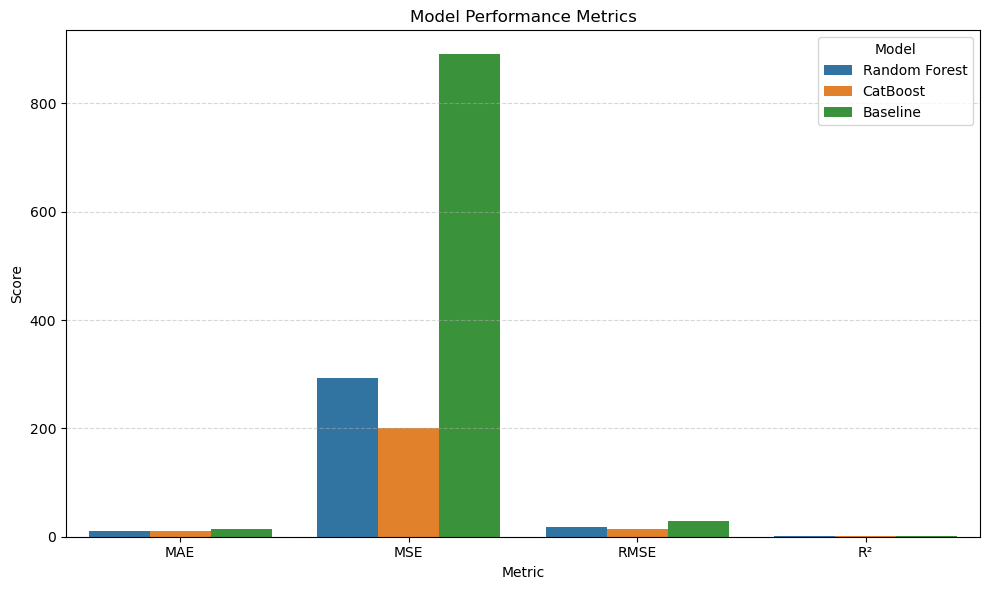

In [211]:
df_long = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='Metric', y='Value', hue='Model')

plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

The results demonstrate that the machine learning pipeline effectively enhanced model performance through a well-structured sequence of steps including data preprocessing, feature encoding and scaling.

Among the tested models, CatBoost was the best performer, achieving the lowest MAE (9.70), MSE (200.45), and RMSE (14.16), alongside the highest R² score (0.8373), indicating accurate and consistent predictions.

Random Forest followed with slightly higher error metrics and an R² of 0.7622, still reflecting good performance.

Baseline model, likely a simpler or default predictor, showed significantly higher error values and the lowest effectiveness in capturing data variability, despite an R² of 0.7581.